 ## Jet Training data

There are some notable kinematic differences between our training data (the pion sample) and the jet data used in this directory (see the plots in `JetClustering.ipynb`).

Ideally, we want to get ahold of some better training data, which mirrors the kinematics & conditions of our jet data. What's important is that the training data has *labels*: Since we're classifying topo-clusters and then performing energy regressions, we need to know if they come from charged or neutral pions. Our jet data does not have this information, which is why we can't just set aside some of it for training. In other words, we need information that we just don't have.

*However*, we can try (imperfectly?) to deduce this information from what we're given. Our jet dataset *does* include some Pythia truth-level information from each event -- this is a list of particles' momenta, their ID's, and their statuses (final-state or not). So we can perhaps try to match topo-clusters with the nearest pion that we find in the truth-level data. Of course, a matching scheme like that is bound to not be 100% accurate, especially when there may be pions near on another and decay streams that cross in $(\eta, \phi)$.

In [1]:
pdg_codes = {
    'pi0':111,
    'piplus':211,
    'piminus':-211
}

In [2]:
skip_matching = False
file_overwrite = False

In [3]:
# Imports - generic stuff
import numpy as np
from numba import jit
import subprocess as sub
import ROOT as rt
import uproot as ur # uproot for accessing ROOT files quickly (and in a Pythonic way)
import sys, os, glob, uuid # glob for searching for files, uuid for random strings to name ROOT objects and avoid collisions
from pathlib import Path

path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import qol_util as qu # for progress bar

data_dir = path_prefix + 'data/jet'

Welcome to JupyROOT 6.22/02


In [4]:
# our "local" data dir, where we create modified data files
jet_data_dir = path_prefix + 'jets/training'
Path(jet_data_dir).mkdir(parents=True, exist_ok=True)

data_filenames = glob.glob(data_dir + '/' + '*.root')

    
# Get the original data.
files = {name:rt.TFile(name,'READ') for name in data_filenames}

# Some data files might be missing an EventTree.
# For now, we will skip these because our methods count on an existing EventTree.
delete_keys = []
for key, val in files.items():
    file_keys = [x.GetName() for x in val.GetListOfKeys()]
    if('ClusterTree' not in file_keys or 'EventTree' not in file_keys):
        delete_keys.append(key)

for key in delete_keys: 
    if(skip_matching): continue
    print('Ignoring file:',key,'(no EventTree/ClusterTree found).')
    del files[key]

# now we make a local copy of the files in the jet_data_dir, keeping only certain branches
active_branches = {}
active_branches['cluster'] = [
    'runNumber',
    'eventNumber',
    'truthE',
    'truthPt',
    'truthEta',
    'truthPhi',
    'clusterIndex',
    'nCluster',
    'clusterE',
    'clusterECalib',
    'clusterPt',
    'clusterEta',
    'clusterPhi',
    'cluster_nCells',
    'cluster_ENG_CALIB_TOT',
    'EMB1',
    'EMB2',
    'EMB3',
    'TileBar0',
    'TileBar1',
    'TileBar2'
]
active_branches['event'] = [
    'runNumber',
    'eventNumber',
    'nTruthPart',
    'pdgId',
    'truthPartPt',
    'truthPartEta',
    'truthPartPhi',
    'truthPartE',
    'clusterCount',
    'nCluster',
    'clusterE',
    'clusterPt',
    'clusterEta',
    'clusterPhi',
]

tree_names = {'cluster':'ClusterTree','event':'EventTree'}
data_filenames = []
old_files = []

l = len(files.keys())
i = 0

if(not skip_matching): qu.printProgressBarColor(i, l, prefix='Copying data files:', suffix='Complete', length=50)

for path, tfile in files.items():
    if(skip_matching): continue
    filename_new = jet_data_dir + '/' + path.split('/')[-1]
    
    if(not file_overwrite):
        if(Path(filename_new).is_file()):
            i+=1
            qu.printProgressBarColor(i, l, prefix='Copying data files:', suffix='Complete', length=50)
            old_files.append(filename_new)
            continue

    old_trees = {x:tfile.Get(tree_names[x]) for x in tree_names.keys()}
    
    for key, tree in old_trees.items():
        tree.SetBranchStatus('*',0)
        for bname in active_branches[key]: tree.SetBranchStatus(bname,1)
    
    tfile_new = rt.TFile(filename_new,'RECREATE')
    new_trees = {x:old_trees[x].CloneTree() for x in old_trees.keys()}
    tfile_new.Write()
    data_filenames.append(filename_new)
    i += 1
    qu.printProgressBarColor(i, l, prefix='Copying data files:', suffix='Complete', length=50)
    del old_trees
    del new_trees
    
if(skip_matching): data_filenames = glob.glob(jet_data_dir + '/*.root')

Ignoring file: /local/home/jano/ml4pions/LCStudies/jets/../data/jet/user.angerami.21717971.OutputStream._000502.root (no EventTree/ClusterTree found).
Ignoring file: /local/home/jano/ml4pions/LCStudies/jets/../data/jet/user.angerami.21717971.OutputStream._000077.root (no EventTree/ClusterTree found).
Ignoring file: /local/home/jano/ml4pions/LCStudies/jets/../data/jet/user.angerami.21717971.OutputStream._000225.root (no EventTree/ClusterTree found).
Ignoring file: /local/home/jano/ml4pions/LCStudies/jets/../data/jet/user.angerami.21717971.OutputStream._000270.root (no EventTree/ClusterTree found).
Ignoring file: /local/home/jano/ml4pions/LCStudies/jets/../data/jet/user.angerami.21717971.OutputStream._000481.root (no EventTree/ClusterTree found).
Ignoring file: /local/home/jano/ml4pions/LCStudies/jets/../data/jet/user.angerami.21717971.OutputStream._000272.root (no EventTree/ClusterTree found).
Ignoring file: /local/home/jano/ml4pions/LCStudies/jets/../data/jet/user.angerami.21717971.Out

In [5]:
# Access the files & trees with uproot
tree_names = {'cluster':'ClusterTree','event':'EventTree'}
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

In [6]:
@jit
def dPhi(phi1, phi2):
    dphi = phi2 - phi1
    if(dphi > np.pi): dphi -= 2. * np.pi
    elif(dphi < -np.pi): dphi += 2. * np.pi
    return dphi

@jit
def dR(eta1,phi1,eta2,phi2):
    return np.sqrt(np.power(eta2 - eta1, 2) + np.power(dPhi(phi1,phi2),2))

In [8]:
tree_name = 'SignalTree'
tree_names['signal'] = tree_name

i2 = 0
prefix = 'Matching topo-clusters to pions:'
l = 0
for dfile, tree in ur_trees.items():
    if(not file_overwrite and dfile in old_files): continue
    nEvent = tree['event'].array('nCluster').shape[0]
    l += nEvent
if(l == 0):
    l = 1
    i2 = 1
if(not skip_matching): qu.printProgressBarColor(i2, l, prefix=prefix, suffix='Complete', length=50)

for dfile, tree in ur_trees.items():
    if(skip_matching): continue
    elif(not file_overwrite and dfile in old_files): continue
    # get pdg codes and figure out which particles are pions
    pdg = tree['event'].array('pdgId')
    pions = (pdg == pdg_codes['pi0']) + (pdg == pdg_codes['piplus']) + (pdg == pdg_codes['piminus']) # TODO: make more Pythonesque
    
    # id, eta and phi of all pions in this file
    pion_id  = pdg[pions]
    pion_eta = tree['event'].array('truthPartEta')[pions]
    pion_phi = tree['event'].array('truthPartPhi')[pions]
    
    # eta and phi of all clusters in this file
    cluster_eta = tree['cluster'].array('clusterEta')
    cluster_phi = tree['cluster'].array('clusterPhi')

    # get number of clusters and events in the file
    nCluster = tree['cluster'].array('clusterE').shape[0]
    nEvent = tree['event'].array('nCluster').shape[0]
    
    # Make an array to fill with signal/background flags, for this file.
    # One entry per cluster.
    signal_flags = np.zeros(nCluster, dtype=np.dtype('i2'))
    
    # now we want to loop over events
    for i in range(nEvent):
        
        # indices of first and last clusters in this event
        ci = tree['event'].array('clusterCount')[i]
        cf = ci + tree['event'].array('nCluster')[i] - 1
        
        # Loop over the clusters in this event, and match to the nearest pion. One pion can be associated with multiple topo-clusters.
        for j in range(ci,cf+1):
            distances = [dR(cluster_eta[j], cluster_phi[j], pion_eta[i,k],pion_eta[i,k]) for k in range(len(pion_eta[i]))]
            min_k = np.argmin(distances)
            code = pion_id[i,min_k]            
            if((code == pdg_codes['piplus']) or (code == pdg_codes['piminus'])): signal_flags[j] = 1
        i2 += 1  
        qu.printProgressBarColor(i2, l, prefix=prefix, suffix='Complete', length=50)
        
    # now add the signal flags to the file, in a new TTree
    f = rt.TFile(dfile,'UPDATE')
    t = rt.TTree(tree_name,tree_name)
    branch_buffer = np.zeros(1,dtype=np.dtype('i2'))
    t.Branch('signalFlag',branch_buffer,'signalFlag/S')
    
    for i in range(len(signal_flags)):
        branch_buffer[0] = signal_flags[i]
        t.Fill()
        
    t.Write()
    f.Close()
    
# refresh our uproot trees, adding access to SignalTree
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

Matching topo-clusters to pions: |██████████████████████████████████████████████████| 100.0% Complete


Now we want to make files for `pi0`, and `piminus` + `piplus`.

In [10]:
#piplus.root will also contain piminus entries
flags = {
    'pi0':0,
    'piplus':1
}

In [ ]:
i = 0
for dfile in ur_trees.keys():
    f = rt.TFile(dfile,'READ')
    t1 = f.Get('ClusterTree')
    t2 = f.Get('SignalTree')
    t1.AddFriend(t2) # make trees friends, so that we can use signalFlag selections on ClusterTree
    
    # Now make a new file to copy events into. One for signal (piplus), one for background (pi0).
    for key, flag in flags.items():
        g = rt.TFile(jet_data_dir + '/' + key + '_' + str(i) + '.root','RECREATE')
        g.cd()
        t3 = t1.CopyTree('signalFlag == ' + str(flag)) # now copy tree with selections directly to file (not into memory!!!)
        t3.Write()
        g.Close()
    
    f.Close()
    i += 1

# now combine all the pi0 and piplus/piminus files, using ROOT's hadd utility
command = 'hadd Y/X.root Y/X*.root'
command = command.replace('Y',jet_data_dir)
for key in flags.keys():
    sub.check_call(command.replace('X',key),shell=True)
    sub.check_call('rm Y/X*_*.root'.replace('Y',jet_data_dir).replace('X',key),shell=True)

Now, we probably want to slim down our training files, otherwise we will be testing on all the same data we're training on (and that'll be a textbook example of over-fitting). Ideally we'd totally separate training and testing data, but I'll save that for another time...

We may also want to ensure that we have the same number of signal and background events. This was not the case for our original data, and it may have some effect on classification (at least making it a 50/50 split will make it easier to read off accuracy).

First, let's make some kinematic plots.

In [11]:
training_files = list(flags.keys())
training_files = [jet_data_dir + '/' + x + '.root' for x in training_files]

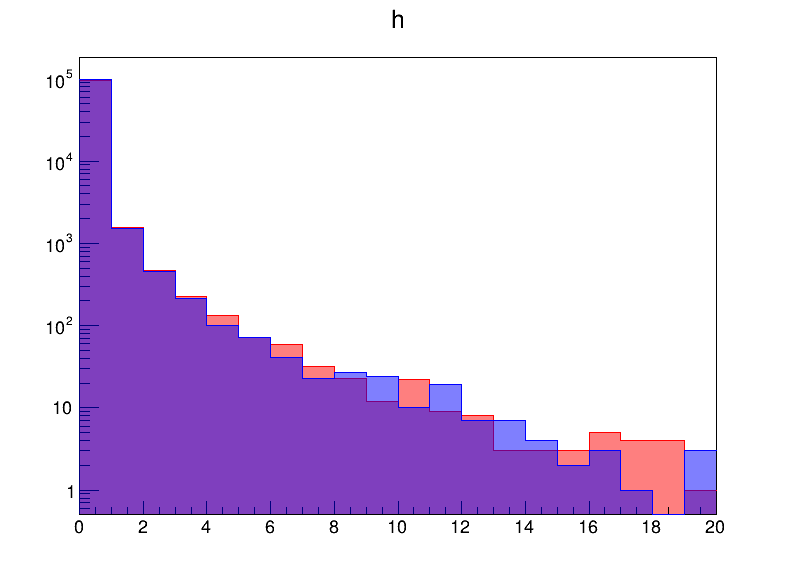

In [19]:
rt.gStyle.SetOptStat(0)
c = rt.TCanvas(str(uuid.uuid4()),'c',800,600)

hists = []
for file in training_files:
    h = rt.TH1F(str(uuid.uuid4()), 'h',20,0.,20.)
    f = rt.TFile(file,'READ')
    t = f.Get('ClusterTree')
    n = t.GetEntries()
    for i in range(n):
        t.GetEntry(i)
        h.Fill(t.cluster_ENG_CALIB_TOT)
    f.Close()
    hists.append(h)
    
hists[0].SetLineColor(rt.kRed)
hists[0].SetFillColorAlpha(rt.kRed, 0.5)
hists[1].SetLineColor(rt.kBlue)
hists[1].SetFillColorAlpha(rt.kBlue, 0.5)


c.cd()
c.SetLogy()
hists[0].Draw('HIST')
hists[1].Draw('HIST SAME')
c.Draw()

Based on all this, we can come up with at least $3$ different strategies for selecting the training data:

    1) Just take all of the data -- don't worry about overtraining (`strat` = 1).

    2) Take some randomized subset of the data, don't worry about kinematics (`strat = 2).
    
    3) Take some randomized subset of the data, where it has been binned in $E_\text{calib}^\text{tot}$, with an equal number of events from each bin.
    
The third option seems most appealing to me, but from the above we see that the number of events decreases very quickly as a function of $E_\text{calib}^\text{tot}$, so that with equal-width bins we would end up with a very small number of events if we don't drop higher values of $E_\text{calib}^\text{tot}$.

In [ ]:
nentries = 100000 # we have far more signal and background than this, so it's a safe pick
strat = 2

In [ ]:
if(strat == 1):
    for file in training_files:
        f = rt.TFile(file,'READ')
        t = f.Get('ClusterTree')
        t.SetBranchStatus('*',1)
        file2 = file.replace('.root','_new.root')
        g = rt.TFile(file2,'RECREATE')
        t2 = t.CloneTree(nentries)
        t2.Write()
        g.Close()
        f.Close()
        sub.check_call('rm X'.replace('X',file),shell=True)
        sub.check_call('mv X Y'.replace('X',file2).replace('Y',file),shell=True)

if(strat == 2):
    # make sure we're not taking too many entries
    for file in training_files:
        f = rt.TFile(file,'READ')
        t = f.Get('ClusterTree')
        n = t.GetEntries()
        f.Close()
        assert(n >= nentries)
    
    # now we'll *randomly* copy entries
    for file in training_files:
        f = rt.TFile(file,'READ')
        t = f.Get('ClusterTree')
        n = t.GetEntries()
    
        indices = np.sort(np.random.choice(n,nentries,replace=False))
    
        file2 = file.replace('.root','_new.root')
        g = rt.TFile(file2,'RECREATE')
        t2 = t.CloneTree(0)
    
        for idx in indices:
            t.GetEntry(idx)
            t2.Fill()
        
        t2.Write()
        g.Close()
        f.Close()
        sub.check_call('rm X'.replace('X',file),shell=True)
        sub.check_call('mv X Y'.replace('X',file2).replace('Y',file),shell=True)    